# **Übung 1, Aufgabe 3 (Erweiterung des Grundmodells)**

**Einordnung in Übung 1:**

- Aufgabe 1: Grundmodell der Produktionsprogrammplanung (PPP)
- Aufgabe 2: Grundmodell mit Zielkonflikt
- **Aufgabe 3: Erweiterung um mehrere Perioden und Lagerbestände**

## **Aufgabenstellung (Klausur WS 2010/11)** 

- Das Produktprogramm eines Unternehmens umfasst die beiden Endprodukte A und B.
- In der Fertigung von A und B wird jeweils ein Zwischenprodukt C benötigt, das in Eigenfertigung hergestellt wird.
- Die Produktion eines Endproduktes kann inklusive der Fertigung der notwendigen Zwischenprodukte in einer Periode abgeschlossen werden.

- Für die kommenden fünf Perioden liegen die folgenden Bedarfe vor:

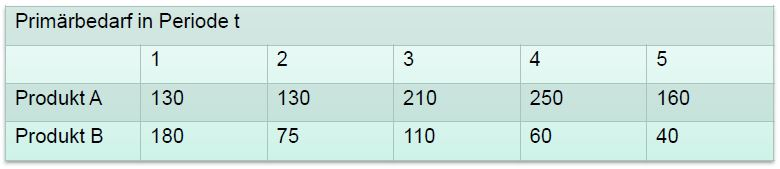

In [1]:
from IPython.display import Image
Image(filename='Images/A3_data1.JPG', width=600)

- Der Bedarf ist vollständig zu befriedigen. 
- In der Endmontage der beiden Endprodukte können insgesamt pro Schicht maximal 20 ME (A und B zusammen) und in der Vorfertigung des Zwischenproduktes können pro Schicht maximal 10 Mengeneinheiten hergestellt werden.
- Jede Planungsperiode umfasst 20 Arbeitstage. Die Endmontage arbeitet im Einschichtbetrieb, die Vorfertigung im Zweischichtbetrieb.

- Zu Beginn der ersten Periode liegen folgende Lagerbestände vor:

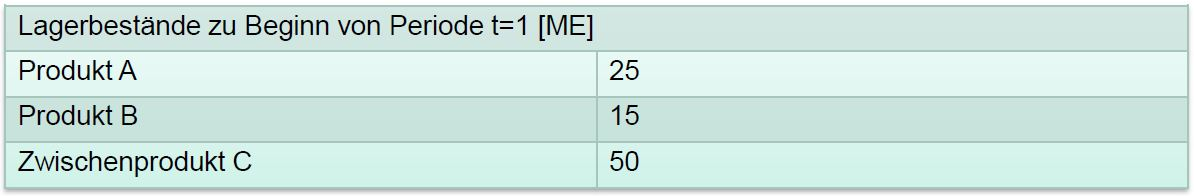

In [2]:
from IPython.display import Image
Image(filename='Images/A3_data2.JPG', width=700)

- Die Lagerung von Zwischenprodukt C ist beschränkt auf 100 ME, ein Sicherheitsbestand von 20 ME ist einzuhalten.
- Die Lagerung der Produkte A, B und C verursachen konstante Kosten von 1 und 1,25 und 0,8 GE/(ME*Periode).

## **Vorbereitung**

### **Python-Module**

In [3]:
import numpy as np
import pandas as pd
from pulp import *
from itertools import islice
import matplotlib.pyplot as plt

### **Daten aus der Aufgabenstellung**

**Primärbedarf / Nachfrage:**

In [4]:
d = pd.DataFrame()

d.loc['A', 1] = 130
d.loc['A', 2] = 130
d.loc['A', 3] = 210
d.loc['A', 4] = 250
d.loc['A', 5] = 160

d.loc['B', 1] = 180
d.loc['B', 2] = 75
d.loc['B', 3] = 110
d.loc['B', 4] = 60
d.loc['B', 5] = 40

d.loc['C'] = 0 # Zwischenprodukt C

Produkte = d.index.tolist()
Perioden = d.columns.tolist()

print(d)

       1      2      3      4      5
A  130.0  130.0  210.0  250.0  160.0
B  180.0   75.0  110.0   60.0   40.0
C    0.0    0.0    0.0    0.0    0.0


$$ $$
**Direktbedarf an Vorprodukten:**

In [5]:
A = pd.DataFrame(index=Produkte, columns=Produkte) # Direktbedarfsmatrix

A.loc['C','A'] = 1
A.loc['C','B'] = 1

A = A.fillna(0)

print(A)

   A  B  C
A  0  0  0
B  0  0  0
C  1  1  0


$$ $$
**Maximale Kapazitäten der zwei Abteilungen:**

In [11]:
# Kapazitaeten
r_Vorfertigung = 400 # 20*20*1
r_Endmontage = 400 # 10*20*2

$$ $$
**Angaben zur Lagerhaltung:**

In [12]:
# Weitere Inputdaten

data = pd.DataFrame()

data.loc['A','Lagerkosten'] = 1.00
data.loc['B','Lagerkosten'] = 1.25
data.loc['C','Lagerkosten'] = 0.80

data.loc['A','Anfangsbestand'] = 25
data.loc['B','Anfangsbestand'] = 15
data.loc['C','Anfangsbestand'] = 50

data.loc['C','Mindestbestand'] = 20
data.loc['C','Maximalbestand'] = 100

print(data)

   Lagerkosten  Anfangsbestand  Mindestbestand  Maximalbestand
A         1.00            25.0             NaN             NaN
B         1.25            15.0             NaN             NaN
C         0.80            50.0            20.0           100.0


$$ $$
## **Optimierungsproblem**

#### **Problemformulierung**


$$\min \sum_{i}\sum_{t}x_{i,t}^{L} \cdot c_i^{L}$$

$$ Restriktionen: $$

$$ x_{A,t}^{P} + x_{B,t}^{P} \leq r_{Endmontage} \quad \forall t \in T $$

$$ x_{C,t}^{P} \leq r_{Vorfertigung} \quad \forall t \in T $$

$$ x_{i,t}^{L} = x_{i,t-1}^{L} + x_{i,t}^{P} - \pi_{i,t} - \sigma_{i,t} \quad \forall i \in I, \forall t \in T $$

$$ x_{i,t}^{L} \geq x_{i,t}^{L^{min}} \quad \forall i \in I, \forall t \in T $$

$$ x_{i,t}^{L} \leq x_{i,t}^{L^{max}} \quad \forall i \in I, \forall t \in T $$

$$ x_{i,t}^{P}, x_{i,t}^{L} \geq 0 \quad \forall i \in I, \forall t \in T $$

$$ \textrm{mit Produkten $I$ und Perioden $T$} $$
$$ \textrm{Anm.: $\pi_{i,t}$: Primärbedarf, $\sigma_{i,t}$: Sekundärbedarf} $$.


#### **Formulierung mit PuLP**

In [13]:
prob = LpProblem('Problem_Erweiterung', LpMinimize)

xP = LpVariable.dicts('Produktionsmenge', (Produkte, Perioden), lowBound=0)
xL = LpVariable.dicts('Lagermenge', (Produkte, Perioden), lowBound=0)

prob += lpSum([xL[i][t]*data.loc[i,'Lagerkosten'] for i in Produkte for t in Perioden])

for t in Perioden:
    prob += xP['A'][t] + xP['B'][t] <= r_Endmontage
    prob += xP['C'][t] <= r_Vorfertigung
                
for i in Produkte:
    prob += xL[i][1] == data.loc[i,'Anfangsbestand'] + xP[i][1] - d.loc[i,1] - lpSum([xP[j][1] * A.loc[i,j] for j in Produkte])
    for t in list(islice(Perioden, 1, None)):
        prob += xL[i][t] == xL[i][t-1] + xP[i][t] - d.loc[i,t] - lpSum([xP[j][t] * A.loc[i,j] for j in Produkte])
        
for t in Perioden:
    prob += xL['C'][t] >= data.loc['C','Mindestbestand']
    prob += xL['C'][t] <= data.loc['C','Maximalbestand']
                
#print(prob)

$$ $$
#### **Ergebnis**

In [14]:
prob.writeLP("Problem_Erweiterung.lp")
prob.solve()

print()
print()
print("Status:", LpStatus[prob.status])
print("Gesamtkosten = {:,.0f} GE".format(value(prob.objective)))
print()
print()

Results = pd.DataFrame()

for i in Produkte:
    for t in Perioden:
        Results.loc[t, 'Bedarf_'+str(i)] = d.loc[i,t]
        Results.loc[t, 'Produktion_'+str(i)] = xP[i][t].varValue        
    Results.loc[1, 'LagerStart_'+str(i)] = data.loc[i,'Anfangsbestand']
    for t in list(islice(Perioden, 1, None)):   
        Results.loc[t, 'LagerStart_'+str(i)] = xL[i][t-1].varValue
    for t in Perioden:       
        Results.loc[t, 'LagerEnd_'+str(i)] = xL[i][t].varValue
    
Results['Bedarf_A+B'] = Results['Bedarf_A'] + Results['Bedarf_B']
Results['Produktion_A+B'] = Results['Produktion_A'] + Results['Produktion_B']
Results['LagerStart_A+B'] = Results['LagerStart_A'] + Results['LagerStart_B']
       
print(Results)



Status: Optimal
Gesamtkosten = 80 GE


   Bedarf_A  Produktion_A  LagerStart_A  LagerEnd_A  Bedarf_B  Produktion_B  \
1     130.0         105.0          25.0         0.0     180.0         165.0   
2     130.0         130.0           0.0         0.0      75.0          75.0   
3     210.0         210.0           0.0         0.0     110.0         110.0   
4     250.0         250.0           0.0         0.0      60.0          60.0   
5     160.0         160.0           0.0         0.0      40.0          40.0   

   LagerStart_B  LagerEnd_B  Bedarf_C  Produktion_C  LagerStart_C  LagerEnd_C  \
1          15.0         0.0       0.0         240.0          50.0        20.0   
2           0.0         0.0       0.0         205.0          20.0        20.0   
3           0.0         0.0       0.0         320.0          20.0        20.0   
4           0.0         0.0       0.0         310.0          20.0        20.0   
5           0.0         0.0       0.0         200.0          20.0        20.0  

$$ $$
#### **Zeitlicher Verlauf**

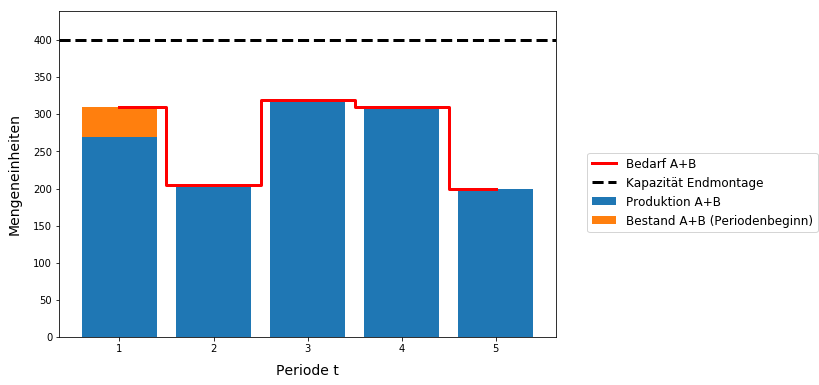

In [15]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

y_max = max([Results['Bedarf_A+B'].max(), r_Endmontage])

p1 = plt.bar(Results.index, Results['Produktion_A+B'], label='Produktion A+B')
p2 = plt.bar(Results.index, Results['LagerStart_A+B'], bottom=Results['Produktion_A+B'], label='Bestand A+B (Periodenbeginn)')
p3 = plt.step(Results.index, Results['Bedarf_A+B'], color='red', where='mid', linewidth=3, label='Bedarf A+B')
p4 = plt.axhline(y=r_Endmontage, linewidth=3, color='black', linestyle='dashed', label='Kapazität Endmontage')

plt.xlabel('Periode t', fontsize=14, labelpad=10)
plt.ylabel('Mengeneinheiten', fontsize=14, labelpad=12)
plt.ylim(0, 1.1*y_max)
fig.legend(loc="center right", fontsize=12, borderaxespad=0.2)
plt.subplots_adjust(right=0.7)

plt.show()